In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn import metrics
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

#Data

In [ ]:
def concatenate_fasta_files(file1_path, file2_path, output_path):
    with open(file1_path, 'r') as file1:
        content1 = file1.read()

    with open(file2_path, 'r') as file2:
        content2 = file2.read()
    concatenated_content = content1 + content2
    with open(output_path, 'w') as output_file:
        output_file.write(concatenated_content)

file1_path = '/content/WuKou_filter-norm_to_512.fasta'
file2_path = '/content/zdna2016_filter-norm_to_512.fasta'
output_path = 'Real_ZDNA.fasta'

concatenate_fasta_files(file1_path, file2_path, output_path)

In [ ]:
file1_path = "/content/Real_ZDNA.fasta"
file2_path = "/content/G4_Chip_seq_quadruplex_norm_to_500.fa"
output_path = 'Real_F.fasta'

concatenate_fasta_files(file1_path, file2_path, output_path)

In [ ]:
real_G_quad = "/content/G4_Chip_seq_quadruplex_norm_to_500.fa"
diff_G_quad = "/content/diff_generated_G4.fasta"
wgan_G_quad = "/content/generated_wgan_G4.fasta"
vae_G_quad = "/content/generated_Gquad_vqvae.fasta"

real_ZDNA = "/content/Real_ZDNA.fasta"
diff_ZDNA = "/content/diff_generated_sequences_ZDNA.fasta"
wgan_ZDNA = "/content/generated_wgan_ZDNA.fasta"
vae_ZDNA = "/content/generated_sequences_ZDNA_vavae.fasta"

real_F = "/content/Real_F.fasta"
diff_F = "/content/diff_generated_sequences_fulldata.fasta"
wgan_F = "/content/wgan_generated_sequences_fulldata.fasta"
vae_F = "/content/generated_sequences_vqvae_fulldata.fasta"

In [ ]:
files = [real_G_quad,
         diff_G_quad,
         wgan_G_quad,
         vae_G_quad,
         real_F,
         diff_F,
         wgan_F,
         vae_F]

In [ ]:
ZDNA_files =[
         real_ZDNA,
         diff_ZDNA,
         wgan_ZDNA,
         vae_ZDNA,
]

In [ ]:
codes = {
 'A': [1., 0., 0., 0., 0.],
 'T': [0., 1., 0., 0., 0.],
 'G': [0., 0., 1., 0., 0.],
 'C': [0., 0., 0., 1., 0.],
 'N': [0., 0., 0., 0., 1.],
 }

In [ ]:
for file in files:
    # Normalisation
    one_hot_quads = []
    line_num = 0
    with open(file, 'r') as f:
      for line in f:
        if line[0] != '>':
          one_hot = []
          for s in line.upper():
            if s != '\n':
              one_hot.append(codes[s])
          one_hot_quads.append(one_hot)
          line_num += 1
    one_hot_quads_np = np.array(one_hot_quads)
    print(f'Shape of {file}', one_hot_quads_np.shape)
    np.save(f'{file}.npy', one_hot_quads_np)

Shape of /content/G4_Chip_seq_quadruplex_norm_to_500.fa (8723, 512, 5)
Shape of /content/diff_generated_G4.fasta (8764, 100, 5)
Shape of /content/generated_wgan_G4.fasta (8723, 100, 5)
Shape of /content/generated_Gquad_vqvae.fasta (8723, 100, 5)
Shape of /content/Real_F.fasta (53022, 512, 5)
Shape of /content/diff_generated_sequences_fulldata.fasta (53388, 100, 5)
Shape of /content/wgan_generated_sequences_fulldata.fasta (53384, 100, 5)
Shape of /content/generated_sequences_vqvae_fulldata.fasta (53384, 100, 5)


In [ ]:
for file in ZDNA_files:
    # Normalisation
    one_hot_quads = []
    line_num = 0
    with open(file, 'r') as f:
      for line in f:
        if line[0] != '>':
          one_hot = []
          for s in line.upper():
            if s != '\n':
              one_hot.append(codes[s])
          one_hot_quads.append(one_hot)
          line_num += 1
    one_hot_quads_np = np.array(one_hot_quads)
    print(f'Shape of {file}', one_hot_quads_np.shape)
    np.save(f'{file}.npy', one_hot_quads_np)

Shape of /content/Real_ZDNA.fasta (44299, 512, 5)
Shape of /content/diff_generated_sequences_ZDNA.fasta (44652, 100, 5)
Shape of /content/generated_wgan_ZDNA.fasta (44661, 512, 5)
Shape of /content/generated_sequences_ZDNA_vavae.fasta (44661, 100, 5)


# Model

In [ ]:
class G4Detector(nn.Module):
    def __init__(self, onehot_len):
        super(G4Detector, self).__init__()
        self.conv1 = nn.Conv1d(onehot_len, 80, 2)
        self.conv2 = nn.Conv1d(onehot_len, 80, 3)
        self.conv3 = nn.Conv1d(onehot_len, 96, 6)
        self.linear_block = nn.Sequential(nn.Linear(256, 32),
                                          nn.ReLU(), nn.Linear(32, 1), nn.Sigmoid())

    def forward(self, x):
        output = x.transpose(1, 2)
        output1 = self.conv1(output)
        output2 = self.conv2(output)
        output3 = self.conv3(output)
        (output1, _) = torch.max(output1, 2)
        (output2, _) = torch.max(output2, 2)
        (output3, _) = torch.max(output3, 2)
        output = torch.cat([output1, output2, output3], dim=1)
        output = self.linear_block(output)
        return output

In [ ]:
detector = G4Detector(onehot_len=5)
detector

G4Detector(
  (conv1): Conv1d(5, 80, kernel_size=(2,), stride=(1,))
  (conv2): Conv1d(5, 80, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(5, 96, kernel_size=(6,), stride=(1,))
  (linear_block): Sequential(
    (0): Linear(in_features=256, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
from sklearn.model_selection import KFold
from sklearn import metrics

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

Text(0.5, 0, 'Recall')

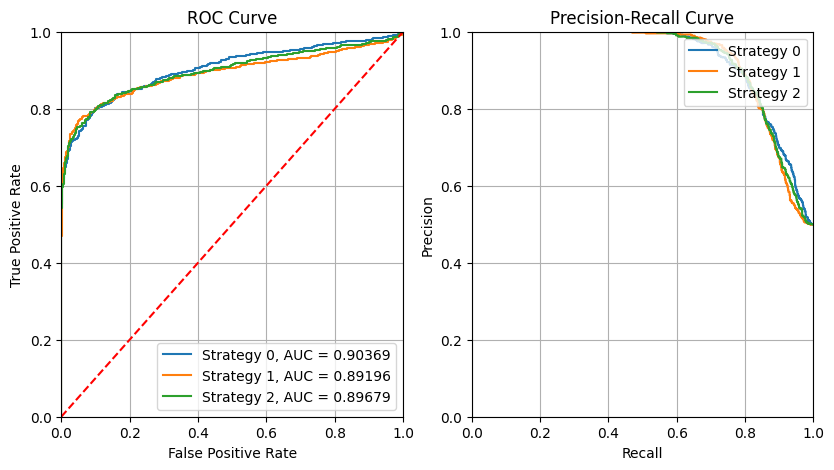

In [ ]:
g4_np_data_path = '/content/G4_Chip_seq_quadruplex_norm_to_500.fa.npy'
batch_size = 128
test_ratio = 0.1
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
use_cuda=True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []
mcc_list = []
accuracy_list = []
aupr_list = []
input_fake = np.load('/content/diff_generated_G4.fasta.npy')
for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/diff_generated_G4.fasta.npy')
    input = input[:, :len(input_fake[1]), :]

    for train_indices, test_indices in kf.split(input):
        if pos_class_strategy == 0:
            x_train_pos = input[train_indices]
        elif pos_class_strategy == 1:
            x_train_pos = input_fake[train_indices]
        elif pos_class_strategy == 2:
            x_train_pos = np.concatenate((input[train_indices], input_fake[train_indices]))

        x_test_pos = input[test_indices]
        y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
        y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)
        codes = np.eye(5)
        # Generate negative data
        x_train_neg, x_test_neg = [], []
        if negative_class_strategy == 0:
            for i in range(x_train_pos.shape[0]):
                x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                          size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                        0.25, 0.25, 0])])
            x_train_neg = np.array(x_train_neg)

            for i in range(y_test_pos.shape[0]):
                x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                         size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                      0.25, 0.25, 0])])
            x_test_neg = np.array(x_test_neg)

        elif negative_class_strategy == 1:
            for x_tp in x_train_pos:
                x_train_neg.append(np.random.permutation(x_tp))
            x_train_neg = np.array(x_train_neg)
            for x_tp in x_test_pos:
                x_test_neg.append(np.random.permutation(x_tp))
            x_test_neg = np.array(x_test_neg)

        y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
        y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

        x_np_train = np.concatenate((x_train_pos, x_train_neg))
        y_np_train = np.concatenate((y_train_pos, y_train_neg))
        x_np_test = np.concatenate((x_test_pos, x_test_neg))
        y_np_test = np.concatenate((y_test_pos, y_test_neg))

        x_train_t = torch.Tensor(x_np_train)
        y_train_t = torch.Tensor(y_np_train)
        x_test_t = torch.Tensor(x_np_test)
        y_test_t = torch.Tensor(y_np_test)

        train_data = TensorDataset(x_train_t, y_train_t)
        test_data = TensorDataset(x_test_t, y_test_t)

        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

        lr = 0.0001
        beta_1 = 0.9
        beta_2 = 0.99
        net = G4Detector(5)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

        for epoch in range(5):
            for (i, data) in enumerate(train_dataloader, 0):
                inputs, labels = data
                optimizer.zero_grad()
                if use_cuda:
                    inputs.cuda()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        all_labels, all_outputs = [], []
        for (i, data) in enumerate(test_dataloader, 0):
            inputs, labels = data
            outputs = net(inputs)
            all_labels.append(labels.numpy())
            all_outputs.append(outputs.detach().numpy())

        all_labels = np.concatenate(all_labels)
        all_outputs = np.concatenate(all_outputs)

        # Compute metrics
        fpr, tpr, _ = metrics.roc_curve(all_labels, all_outputs)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
        precision_list.append(precision)
        recall_list.append(recall)

        # AUC
        roc_auc = metrics.auc(fpr, tpr)
        aupr = metrics.average_precision_score(all_labels, all_outputs)
        aupr_list.append(aupr)

        # MCC
        threshold = 0.5
        y_pred_binary = (all_outputs >= threshold).astype(int)
        mcc = metrics.matthews_corrcoef(all_labels, y_pred_binary)
        mcc_list.append(mcc)

        # Accuracy
        accuracy = metrics.accuracy_score(all_labels, y_pred_binary)
        accuracy_list.append(accuracy)

        # F1 score
        f1 = metrics.f1_score(all_labels, y_pred_binary)
        f1_scores_list.append(f1)

# Plotting ROC, PR curves, and reporting metrics
plt.figure(figsize=(15, 5))

# ROC Curves
plt.subplot(1, 3, 1)
plt.title('ROC Curve')
for i, strategy in enumerate(strategies):
    plt.plot(fpr_list[i], tpr_list[i], label=f'Strategy {strategy}, AUC = {metrics.auc(fpr_list[i], tpr_list[i]):.5f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Precision-Recall Curves
plt.subplot(1, 3, 2)
plt.title('Precision-Recall Curve')
for i, strategy in enumerate(strategies):
    plt.plot(recall_list[i], precision_list[i], label=f'Strategy {strategy}')
plt.legend(loc='upper right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('Precision')
plt.xlabel('Recall')

In [ ]:
roc_auc_list = {strategy: [] for strategy in strategies}
mcc_list = {strategy: [] for strategy in strategies}
accuracy_list = {strategy: [] for strategy in strategies}
aupr_list = {strategy: [] for strategy in strategies}
f1_scores_list = {strategy: [] for strategy in strategies}
precision_list = {strategy: [] for strategy in strategies}
recall_list = {strategy: [] for strategy in strategies}

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/diff_generated_G4.fasta.npy')
    input = input[:, :len(input_fake[1]), :]

    for train_indices, test_indices in kf.split(input):
        if pos_class_strategy == 0:
            x_train_pos = input[train_indices]
        elif pos_class_strategy == 1:
            x_train_pos = input_fake[train_indices]
        elif pos_class_strategy == 2:
            x_train_pos = np.concatenate((input[train_indices], input_fake[train_indices]))

        x_test_pos = input[test_indices]
        y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
        y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

        x_train_neg, x_test_neg = [], []
        if negative_class_strategy == 0:
            for i in range(x_train_pos.shape[0]):
                x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                          size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                        0.25, 0.25, 0])])
            x_train_neg = np.array(x_train_neg)

            for i in range(y_test_pos.shape[0]):
                x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                         size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                      0.25, 0.25, 0])])
            x_test_neg = np.array(x_test_neg)

        elif negative_class_strategy == 1:
            for x_tp in x_train_pos:
                x_train_neg.append(np.random.permutation(x_tp))
            x_train_neg = np.array(x_train_neg)
            for x_tp in x_test_pos:
                x_test_neg.append(np.random.permutation(x_tp))
            x_test_neg = np.array(x_test_neg)

        y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
        y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

        x_np_train = np.concatenate((x_train_pos, x_train_neg))
        y_np_train = np.concatenate((y_train_pos, y_train_neg))
        x_np_test = np.concatenate((x_test_pos, x_test_neg))
        y_np_test = np.concatenate((y_test_pos, y_test_neg))

        x_train_t = torch.Tensor(x_np_train)
        y_train_t = torch.Tensor(y_np_train)
        x_test_t = torch.Tensor(x_np_test)
        y_test_t = torch.Tensor(y_np_test)

        train_data = TensorDataset(x_train_t, y_train_t)
        test_data = TensorDataset(x_test_t, y_test_t)

        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

        net = G4Detector(5)
        optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

        for epoch in range(5):
            for (i, data) in enumerate(train_dataloader, 0):
                inputs, labels = data
                optimizer.zero_grad()
                if use_cuda:
                    inputs.cuda()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate
        all_labels, all_outputs = [], []
        for (i, data) in enumerate(test_dataloader, 0):
            inputs, labels = data
            outputs = net(inputs)
            all_labels.append(labels.numpy())
            all_outputs.append(outputs.detach().numpy())

        all_labels = np.concatenate(all_labels)
        all_outputs = np.concatenate(all_outputs)

        fpr, tpr, _ = metrics.roc_curve(all_labels, all_outputs)
        roc_auc = metrics.auc(fpr, tpr)
        roc_auc_list[pos_class_strategy].append(roc_auc)

        precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
        precision_list[pos_class_strategy].append(precision)
        recall_list[pos_class_strategy].append(recall)

        aupr = metrics.average_precision_score(all_labels, all_outputs)
        aupr_list[pos_class_strategy].append(aupr)

        y_pred_binary = (all_outputs >= 0.5).astype(int)
        mcc = metrics.matthews_corrcoef(all_labels, y_pred_binary)
        mcc_list[pos_class_strategy].append(mcc)

        accuracy = metrics.accuracy_score(all_labels, y_pred_binary)
        accuracy_list[pos_class_strategy].append(accuracy)

        f1 = metrics.f1_score(all_labels, y_pred_binary)
        f1_scores_list[pos_class_strategy].append(f1)

In [ ]:
for i, strategy in enumerate(strategies):
    print(f"Strategy {strategy}:")
    print(f"ROC AUC: {np.mean(roc_auc_list[strategy]):.3f} ± {np.std(roc_auc_list[strategy]):.3f}")
    print(f"Precision: {np.mean([np.mean(p) for p in precision_list[strategy]]):.3f} ± {np.std([np.mean(p) for p in precision_list[strategy]]):.3f}")
    print(f"Recall: {np.mean([np.mean(r) for r in recall_list[strategy]]):.3f} ± {np.std([np.mean(r) for r in recall_list[strategy]]):.3f}")
    print(f"F1 Score: {np.mean(f1_scores_list[strategy]):.3f} ± {np.std(f1_scores_list[strategy]):.3f}")
    print(f"MCC: {np.mean(mcc_list[strategy]):.3f} ± {np.std(mcc_list[strategy]):.3f}")
    print(f"Accuracy: {np.mean(accuracy_list[strategy]):.3f} ± {np.std(accuracy_list[strategy]):.3f}")
    print(f"AUPR: {np.mean(aupr_list[strategy]):.3f} ± {np.std(aupr_list[strategy]):.3f}")

Strategy 0:
ROC AUC: 0.894 ± 0.009
Precision: 0.801 ± 0.004
Recall: 0.697 ± 0.004
F1 Score: 0.822 ± 0.023
MCC: 0.707 ± 0.022
Accuracy: 0.844 ± 0.015
AUPR: 0.926 ± 0.006
Strategy 1:
ROC AUC: 0.880 ± 0.003
Precision: 0.795 ± 0.002
Recall: 0.690 ± 0.002
F1 Score: 0.795 ± 0.022
MCC: 0.676 ± 0.017
Accuracy: 0.824 ± 0.013
AUPR: 0.916 ± 0.003
Strategy 2:
ROC AUC: 0.905 ± 0.008
Precision: 0.805 ± 0.004
Recall: 0.702 ± 0.004
F1 Score: 0.842 ± 0.010
MCC: 0.721 ± 0.016
Accuracy: 0.855 ± 0.009
AUPR: 0.932 ± 0.006


In [ ]:
input_fake = np.load('/content/generated_wgan_ZDNA.fasta.npy')
input_fake = np.load('/content/diff_generated_G4.fasta.npy')

In [ ]:
g4_np_data_path = '/content/G4_Chip_seq_quadruplex_norm_to_500.fa.npy'
batch_size = 128
test_ratio = 0.1
hidden_state_len = 128
shuffle_train_each_epoch = True
use_cuda=True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]


fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []
mcc_list = []
accuracy_list = []
aupr_list = []
input_fake = np.load('/content/generated_Gquad_vqvae.fasta.npy')
for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/generated_Gquad_vqvae.fasta.npy')
    input = input[:, :len(input_fake[1]), :]

    for train_indices, test_indices in kf.split(input):
        # Split into train and test based on fold indices
        if pos_class_strategy == 0:
            x_train_pos = input[train_indices]
        elif pos_class_strategy == 1:
            x_train_pos = input_fake[train_indices]
        elif pos_class_strategy == 2:
            x_train_pos = np.concatenate((input[train_indices], input_fake[train_indices]))

        x_test_pos = input[test_indices]
        y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
        y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)
        codes = np.eye(5)
        # Generate negative data
        x_train_neg, x_test_neg = [], []
        if negative_class_strategy == 0:
            for i in range(x_train_pos.shape[0]):
                x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                          size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                        0.25, 0.25, 0])])
            x_train_neg = np.array(x_train_neg)

            for i in range(y_test_pos.shape[0]):
                x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                         size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                      0.25, 0.25, 0])])
            x_test_neg = np.array(x_test_neg)

        elif negative_class_strategy == 1:
            for x_tp in x_train_pos:
                x_train_neg.append(np.random.permutation(x_tp))
            x_train_neg = np.array(x_train_neg)
            for x_tp in x_test_pos:
                x_test_neg.append(np.random.permutation(x_tp))
            x_test_neg = np.array(x_test_neg)

        y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
        y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

        x_np_train = np.concatenate((x_train_pos, x_train_neg))
        y_np_train = np.concatenate((y_train_pos, y_train_neg))
        x_np_test = np.concatenate((x_test_pos, x_test_neg))
        y_np_test = np.concatenate((y_test_pos, y_test_neg))

        x_train_t = torch.Tensor(x_np_train)
        y_train_t = torch.Tensor(y_np_train)
        x_test_t = torch.Tensor(x_np_test)
        y_test_t = torch.Tensor(y_np_test)

        train_data = TensorDataset(x_train_t, y_train_t)
        test_data = TensorDataset(x_test_t, y_test_t)

        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

        # Train the model
        lr = 0.0001
        beta_1 = 0.9
        beta_2 = 0.99
        net = G4Detector(5)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

        for epoch in range(5):
            for (i, data) in enumerate(train_dataloader, 0):
                inputs, labels = data
                optimizer.zero_grad()
                if use_cuda:
                    inputs.cuda()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate on the test set
        all_labels, all_outputs = [], []
        for (i, data) in enumerate(test_dataloader, 0):
            inputs, labels = data
            outputs = net(inputs)
            all_labels.append(labels.numpy())
            all_outputs.append(outputs.detach().numpy())

        all_labels = np.concatenate(all_labels)
        all_outputs = np.concatenate(all_outputs)

        # Compute metrics
        fpr, tpr, _ = metrics.roc_curve(all_labels, all_outputs)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
        precision_list.append(precision)
        recall_list.append(recall)

        # AUC
        roc_auc = metrics.auc(fpr, tpr)
        aupr = metrics.average_precision_score(all_labels, all_outputs)
        aupr_list.append(aupr)

        # MCC
        threshold = 0.5
        y_pred_binary = (all_outputs >= threshold).astype(int)
        mcc = metrics.matthews_corrcoef(all_labels, y_pred_binary)
        mcc_list.append(mcc)

        # Accuracy
        accuracy = metrics.accuracy_score(all_labels, y_pred_binary)
        accuracy_list.append(accuracy)

        # F1 score
        f1 = metrics.f1_score(all_labels, y_pred_binary)
        f1_scores_list.append(f1)


plt.figure(figsize=(15, 5))


plt.subplot(1, 3, 1)
plt.title('ROC Curve')
for i, strategy in enumerate(strategies):
    plt.plot(fpr_list[i], tpr_list[i], label=f'Strategy {strategy}, AUC = {metrics.auc(fpr_list[i], tpr_list[i]):.5f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(1, 3, 2)
plt.title('Precision-Recall Curve')
for i, strategy in enumerate(strategies):
    plt.plot(recall_list[i], precision_list[i], label=f'Strategy {strategy}')
plt.legend(loc='upper right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('Precision')
plt.xlabel('Recall')

In [ ]:
roc_auc_list = {strategy: [] for strategy in strategies}
mcc_list = {strategy: [] for strategy in strategies}
accuracy_list = {strategy: [] for strategy in strategies}
aupr_list = {strategy: [] for strategy in strategies}
f1_scores_list = {strategy: [] for strategy in strategies}
precision_list = {strategy: [] for strategy in strategies}
recall_list = {strategy: [] for strategy in strategies}

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/diff_generated_G4.fasta.npy')
    input = input[:, :len(input_fake[1]), :]

    for train_indices, test_indices in kf.split(input):
        if pos_class_strategy == 0:
            x_train_pos = input[train_indices]
        elif pos_class_strategy == 1:
            x_train_pos = input_fake[train_indices]
        elif pos_class_strategy == 2:
            x_train_pos = np.concatenate((input[train_indices], input_fake[train_indices]))

        x_test_pos = input[test_indices]
        y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
        y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

        x_train_neg, x_test_neg = [], []
        if negative_class_strategy == 0:
            for i in range(x_train_pos.shape[0]):
                x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                          size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                        0.25, 0.25, 0])])
            x_train_neg = np.array(x_train_neg)

            for i in range(y_test_pos.shape[0]):
                x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                         size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                      0.25, 0.25, 0])])
            x_test_neg = np.array(x_test_neg)

        elif negative_class_strategy == 1:
            for x_tp in x_train_pos:
                x_train_neg.append(np.random.permutation(x_tp))
            x_train_neg = np.array(x_train_neg)
            for x_tp in x_test_pos:
                x_test_neg.append(np.random.permutation(x_tp))
            x_test_neg = np.array(x_test_neg)

        y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
        y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

        x_np_train = np.concatenate((x_train_pos, x_train_neg))
        y_np_train = np.concatenate((y_train_pos, y_train_neg))
        x_np_test = np.concatenate((x_test_pos, x_test_neg))
        y_np_test = np.concatenate((y_test_pos, y_test_neg))

        x_train_t = torch.Tensor(x_np_train)
        y_train_t = torch.Tensor(y_np_train)
        x_test_t = torch.Tensor(x_np_test)
        y_test_t = torch.Tensor(y_np_test)

        train_data = TensorDataset(x_train_t, y_train_t)
        test_data = TensorDataset(x_test_t, y_test_t)

        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

        net = G4Detector(5)
        optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

        for epoch in range(5):
            for (i, data) in enumerate(train_dataloader, 0):
                inputs, labels = data
                optimizer.zero_grad()
                if use_cuda:
                    inputs.cuda()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate
        all_labels, all_outputs = [], []
        for (i, data) in enumerate(test_dataloader, 0):
            inputs, labels = data
            outputs = net(inputs)
            all_labels.append(labels.numpy())
            all_outputs.append(outputs.detach().numpy())

        all_labels = np.concatenate(all_labels)
        all_outputs = np.concatenate(all_outputs)

        fpr, tpr, _ = metrics.roc_curve(all_labels, all_outputs)
        roc_auc = metrics.auc(fpr, tpr)
        roc_auc_list[pos_class_strategy].append(roc_auc)

        precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
        precision_list[pos_class_strategy].append(precision)
        recall_list[pos_class_strategy].append(recall)

        aupr = metrics.average_precision_score(all_labels, all_outputs)
        aupr_list[pos_class_strategy].append(aupr)

        y_pred_binary = (all_outputs >= 0.5).astype(int)
        mcc = metrics.matthews_corrcoef(all_labels, y_pred_binary)
        mcc_list[pos_class_strategy].append(mcc)

        accuracy = metrics.accuracy_score(all_labels, y_pred_binary)
        accuracy_list[pos_class_strategy].append(accuracy)

        f1 = metrics.f1_score(all_labels, y_pred_binary)
        f1_scores_list[pos_class_strategy].append(f1)

In [ ]:
for i, strategy in enumerate(strategies):
    print(f"Strategy {strategy}:")
    print(f"ROC AUC: {np.mean(roc_auc_list[strategy]):.3f} ± {np.std(roc_auc_list[strategy]):.3f}")
    print(f"Precision: {np.mean([np.mean(p) for p in precision_list[strategy]]):.3f} ± {np.std([np.mean(p) for p in precision_list[strategy]]):.3f}")
    print(f"Recall: {np.mean([np.mean(r) for r in recall_list[strategy]]):.3f} ± {np.std([np.mean(r) for r in recall_list[strategy]]):.3f}")
    print(f"F1 Score: {np.mean(f1_scores_list[strategy]):.3f} ± {np.std(f1_scores_list[strategy]):.3f}")
    print(f"MCC: {np.mean(mcc_list[strategy]):.3f} ± {np.std(mcc_list[strategy]):.3f}")
    print(f"Accuracy: {np.mean(accuracy_list[strategy]):.3f} ± {np.std(accuracy_list[strategy]):.3f}")
    print(f"AUPR: {np.mean(aupr_list[strategy]):.3f} ± {np.std(aupr_list[strategy]):.3f}")

Strategy 0:
ROC AUC: 0.896 ± 0.007
Precision: 0.802 ± 0.003
Recall: 0.698 ± 0.004
F1 Score: 0.831 ± 0.014
MCC: 0.711 ± 0.019
Accuracy: 0.848 ± 0.010
AUPR: 0.927 ± 0.005
Strategy 1:
ROC AUC: 0.880 ± 0.005
Precision: 0.794 ± 0.002
Recall: 0.690 ± 0.003
F1 Score: 0.802 ± 0.021
MCC: 0.679 ± 0.016
Accuracy: 0.828 ± 0.013
AUPR: 0.915 ± 0.004
Strategy 2:
ROC AUC: 0.903 ± 0.007
Precision: 0.804 ± 0.003
Recall: 0.701 ± 0.003
F1 Score: 0.840 ± 0.010
MCC: 0.718 ± 0.018
Accuracy: 0.854 ± 0.009
AUPR: 0.931 ± 0.005


Text(0.5, 0, 'Recall')

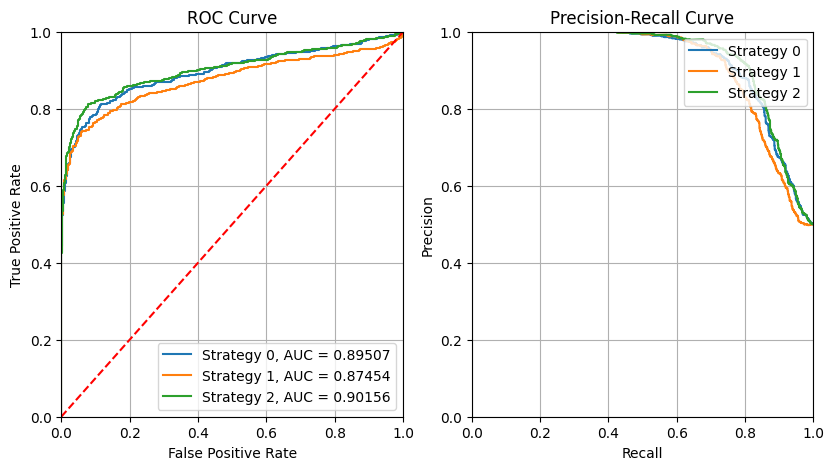

In [ ]:
g4_np_data_path = '/content/G4_Chip_seq_quadruplex_norm_to_500.fa.npy'
batch_size = 128
test_ratio = 0.1
hidden_state_len = 128
shuffle_train_each_epoch = True
use_cuda=True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]


fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []
mcc_list = []
accuracy_list = []
aupr_list = []
input_fake = np.load('/content/generated_sequences_ZDNA_vavae.fasta.npy')
for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/generated_sequences_ZDNA_vavae.fasta.npy')
    input = input[:, :len(input_fake[1]), :]

    for train_indices, test_indices in kf.split(input):
        # Split into train and test based on fold indices
        if pos_class_strategy == 0:
            x_train_pos = input[train_indices]
        elif pos_class_strategy == 1:
            x_train_pos = input_fake[train_indices]
        elif pos_class_strategy == 2:
            x_train_pos = np.concatenate((input[train_indices], input_fake[train_indices]))

        x_test_pos = input[test_indices]
        y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
        y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)
        codes = np.eye(5)
        # Generate negative data
        x_train_neg, x_test_neg = [], []
        if negative_class_strategy == 0:
            for i in range(x_train_pos.shape[0]):
                x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                          size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                        0.25, 0.25, 0])])
            x_train_neg = np.array(x_train_neg)

            for i in range(y_test_pos.shape[0]):
                x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                         size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                      0.25, 0.25, 0])])
            x_test_neg = np.array(x_test_neg)

        elif negative_class_strategy == 1:
            for x_tp in x_train_pos:
                x_train_neg.append(np.random.permutation(x_tp))
            x_train_neg = np.array(x_train_neg)
            for x_tp in x_test_pos:
                x_test_neg.append(np.random.permutation(x_tp))
            x_test_neg = np.array(x_test_neg)

        y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
        y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

        x_np_train = np.concatenate((x_train_pos, x_train_neg))
        y_np_train = np.concatenate((y_train_pos, y_train_neg))
        x_np_test = np.concatenate((x_test_pos, x_test_neg))
        y_np_test = np.concatenate((y_test_pos, y_test_neg))

        x_train_t = torch.Tensor(x_np_train)
        y_train_t = torch.Tensor(y_np_train)
        x_test_t = torch.Tensor(x_np_test)
        y_test_t = torch.Tensor(y_np_test)

        train_data = TensorDataset(x_train_t, y_train_t)
        test_data = TensorDataset(x_test_t, y_test_t)

        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


        lr = 0.0001
        beta_1 = 0.9
        beta_2 = 0.99
        net = G4Detector(5)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

        for epoch in range(5):
            for (i, data) in enumerate(train_dataloader, 0):
                inputs, labels = data
                optimizer.zero_grad()
                if use_cuda:
                    inputs.cuda()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        all_labels, all_outputs = [], []
        for (i, data) in enumerate(test_dataloader, 0):
            inputs, labels = data
            outputs = net(inputs)
            all_labels.append(labels.numpy())
            all_outputs.append(outputs.detach().numpy())

        all_labels = np.concatenate(all_labels)
        all_outputs = np.concatenate(all_outputs)


        fpr, tpr, _ = metrics.roc_curve(all_labels, all_outputs)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
        precision_list.append(precision)
        recall_list.append(recall)

        # AUC
        roc_auc = metrics.auc(fpr, tpr)
        aupr = metrics.average_precision_score(all_labels, all_outputs)
        aupr_list.append(aupr)

        # MCC
        threshold = 0.5
        y_pred_binary = (all_outputs >= threshold).astype(int)
        mcc = metrics.matthews_corrcoef(all_labels, y_pred_binary)
        mcc_list.append(mcc)

        # Accuracy
        accuracy = metrics.accuracy_score(all_labels, y_pred_binary)
        accuracy_list.append(accuracy)

        # F1 score
        f1 = metrics.f1_score(all_labels, y_pred_binary)
        f1_scores_list.append(f1)

# Plotting ROC, PR curves, and reporting metrics
plt.figure(figsize=(15, 5))

# ROC Curves
plt.subplot(1, 3, 1)
plt.title('ROC Curve')
for i, strategy in enumerate(strategies):
    plt.plot(fpr_list[i], tpr_list[i], label=f'Strategy {strategy}, AUC = {metrics.auc(fpr_list[i], tpr_list[i]):.5f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Precision-Recall Curves
plt.subplot(1, 3, 2)
plt.title('Precision-Recall Curve')
for i, strategy in enumerate(strategies):
    plt.plot(recall_list[i], precision_list[i], label=f'Strategy {strategy}')
plt.legend(loc='upper right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('Precision')
plt.xlabel('Recall')

In [ ]:
roc_auc_list = {strategy: [] for strategy in strategies}
mcc_list = {strategy: [] for strategy in strategies}
accuracy_list = {strategy: [] for strategy in strategies}
aupr_list = {strategy: [] for strategy in strategies}
f1_scores_list = {strategy: [] for strategy in strategies}
precision_list = {strategy: [] for strategy in strategies}
recall_list = {strategy: [] for strategy in strategies}

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/generated_sequences_ZDNA_vavae.fasta.npy')
    input = input[:, :len(input_fake[1]), :]

    for train_indices, test_indices in kf.split(input):
        if pos_class_strategy == 0:
            x_train_pos = input[train_indices]
        elif pos_class_strategy == 1:
            x_train_pos = input_fake[train_indices]
        elif pos_class_strategy == 2:
            x_train_pos = np.concatenate((input[train_indices], input_fake[train_indices]))

        x_test_pos = input[test_indices]
        y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
        y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

        x_train_neg, x_test_neg = [], []
        if negative_class_strategy == 0:
            for i in range(x_train_pos.shape[0]):
                x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                          size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                        0.25, 0.25, 0])])
            x_train_neg = np.array(x_train_neg)

            for i in range(y_test_pos.shape[0]):
                x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                         size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                      0.25, 0.25, 0])])
            x_test_neg = np.array(x_test_neg)

        elif negative_class_strategy == 1:
            for x_tp in x_train_pos:
                x_train_neg.append(np.random.permutation(x_tp))
            x_train_neg = np.array(x_train_neg)
            for x_tp in x_test_pos:
                x_test_neg.append(np.random.permutation(x_tp))
            x_test_neg = np.array(x_test_neg)

        y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
        y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

        x_np_train = np.concatenate((x_train_pos, x_train_neg))
        y_np_train = np.concatenate((y_train_pos, y_train_neg))
        x_np_test = np.concatenate((x_test_pos, x_test_neg))
        y_np_test = np.concatenate((y_test_pos, y_test_neg))

        x_train_t = torch.Tensor(x_np_train)
        y_train_t = torch.Tensor(y_np_train)
        x_test_t = torch.Tensor(x_np_test)
        y_test_t = torch.Tensor(y_np_test)

        train_data = TensorDataset(x_train_t, y_train_t)
        test_data = TensorDataset(x_test_t, y_test_t)

        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

        net = G4Detector(5)
        optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

        for epoch in range(5):
            for (i, data) in enumerate(train_dataloader, 0):
                inputs, labels = data
                optimizer.zero_grad()
                if use_cuda:
                    inputs.cuda()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate
        all_labels, all_outputs = [], []
        for (i, data) in enumerate(test_dataloader, 0):
            inputs, labels = data
            outputs = net(inputs)
            all_labels.append(labels.numpy())
            all_outputs.append(outputs.detach().numpy())

        all_labels = np.concatenate(all_labels)
        all_outputs = np.concatenate(all_outputs)

        fpr, tpr, _ = metrics.roc_curve(all_labels, all_outputs)
        roc_auc = metrics.auc(fpr, tpr)
        roc_auc_list[pos_class_strategy].append(roc_auc)

        precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
        precision_list[pos_class_strategy].append(precision)
        recall_list[pos_class_strategy].append(recall)

        aupr = metrics.average_precision_score(all_labels, all_outputs)
        aupr_list[pos_class_strategy].append(aupr)

        y_pred_binary = (all_outputs >= 0.5).astype(int)
        mcc = metrics.matthews_corrcoef(all_labels, y_pred_binary)
        mcc_list[pos_class_strategy].append(mcc)

        accuracy = metrics.accuracy_score(all_labels, y_pred_binary)
        accuracy_list[pos_class_strategy].append(accuracy)

        f1 = metrics.f1_score(all_labels, y_pred_binary)
        f1_scores_list[pos_class_strategy].append(f1)

In [ ]:
for i, strategy in enumerate(strategies):
    print(f"Strategy {strategy}:")
    print(f"ROC AUC: {np.mean(roc_auc_list[strategy]):.3f} ± {np.std(roc_auc_list[strategy]):.3f}")
    print(f"Precision: {np.mean([np.mean(p) for p in precision_list[strategy]]):.3f} ± {np.std([np.mean(p) for p in precision_list[strategy]]):.3f}")
    print(f"Recall: {np.mean([np.mean(r) for r in recall_list[strategy]]):.3f} ± {np.std([np.mean(r) for r in recall_list[strategy]]):.3f}")
    print(f"F1 Score: {np.mean(f1_scores_list[strategy]):.3f} ± {np.std(f1_scores_list[strategy]):.3f}")
    print(f"MCC: {np.mean(mcc_list[strategy]):.3f} ± {np.std(mcc_list[strategy]):.3f}")
    print(f"Accuracy: {np.mean(accuracy_list[strategy]):.3f} ± {np.std(accuracy_list[strategy]):.3f}")
    print(f"AUPR: {np.mean(aupr_list[strategy]):.3f} ± {np.std(aupr_list[strategy]):.3f}")

Strategy 0:
ROC AUC: 0.894 ± 0.007
Precision: 0.801 ± 0.003
Recall: 0.697 ± 0.004
F1 Score: 0.826 ± 0.011
MCC: 0.708 ± 0.014
Accuracy: 0.845 ± 0.007
AUPR: 0.926 ± 0.005
Strategy 1:
ROC AUC: 0.870 ± 0.007
Precision: 0.790 ± 0.003
Recall: 0.685 ± 0.003
F1 Score: 0.674 ± 0.020
MCC: 0.580 ± 0.016
Accuracy: 0.753 ± 0.011
AUPR: 0.908 ± 0.005
Strategy 2:
ROC AUC: 0.898 ± 0.006
Precision: 0.802 ± 0.003
Recall: 0.699 ± 0.003
F1 Score: 0.822 ± 0.011
MCC: 0.707 ± 0.016
Accuracy: 0.843 ± 0.008
AUPR: 0.927 ± 0.004


Text(0.5, 0, 'Recall')

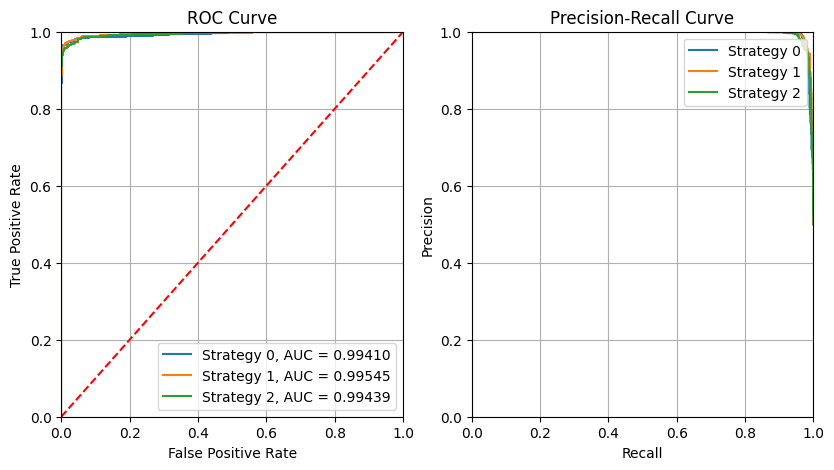

In [ ]:
g4_np_data_path = '/content/G4_Chip_seq_quadruplex_norm_to_500.fa.npy'
batch_size = 128
test_ratio = 0.1
hidden_state_len = 128  # Define the hidden state length
shuffle_train_each_epoch = True
use_cuda=True
pos_class_strategy = 2
negative_class_strategy = 0
# Strategies: 0 for Real Data, 1 for Fake Data, 2 for Real+Fake Data
strategies = [0, 1, 2]

# Lists to store ROC curve data for each strategy
fpr_list = []
tpr_list = []
precision_list = []
recall_list = []
f1_scores_list = []
mcc_list = []
accuracy_list = []
aupr_list = []
input_fake = np.load('/content/generated_wgan_ZDNA.fasta.npy')
for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/generated_wgan_ZDNA.fasta.npy')
    input = input[:, :len(input_fake[1]), :]

    for train_indices, test_indices in kf.split(input):
        # Split into train and test based on fold indices
        if pos_class_strategy == 0:
            x_train_pos = input[train_indices]
        elif pos_class_strategy == 1:
            x_train_pos = input_fake[train_indices]
        elif pos_class_strategy == 2:
            x_train_pos = np.concatenate((input[train_indices], input_fake[train_indices]))

        x_test_pos = input[test_indices]
        y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
        y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)
        codes = np.eye(5)
        # Generate negative data
        x_train_neg, x_test_neg = [], []
        if negative_class_strategy == 0:
            for i in range(x_train_pos.shape[0]):
                x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                          size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                        0.25, 0.25, 0])])
            x_train_neg = np.array(x_train_neg)

            for i in range(y_test_pos.shape[0]):
                x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                         size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                      0.25, 0.25, 0])])
            x_test_neg = np.array(x_test_neg)

        elif negative_class_strategy == 1:
            for x_tp in x_train_pos:
                x_train_neg.append(np.random.permutation(x_tp))
            x_train_neg = np.array(x_train_neg)
            for x_tp in x_test_pos:
                x_test_neg.append(np.random.permutation(x_tp))
            x_test_neg = np.array(x_test_neg)

        y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
        y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

        x_np_train = np.concatenate((x_train_pos, x_train_neg))
        y_np_train = np.concatenate((y_train_pos, y_train_neg))
        x_np_test = np.concatenate((x_test_pos, x_test_neg))
        y_np_test = np.concatenate((y_test_pos, y_test_neg))

        x_train_t = torch.Tensor(x_np_train)
        y_train_t = torch.Tensor(y_np_train)
        x_test_t = torch.Tensor(x_np_test)
        y_test_t = torch.Tensor(y_np_test)

        train_data = TensorDataset(x_train_t, y_train_t)
        test_data = TensorDataset(x_test_t, y_test_t)

        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

        # Train the model
        lr = 0.0001
        beta_1 = 0.9
        beta_2 = 0.99
        net = G4Detector(5)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

        for epoch in range(5):
            for (i, data) in enumerate(train_dataloader, 0):
                inputs, labels = data
                optimizer.zero_grad()
                if use_cuda:
                    inputs.cuda()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate on the test set
        all_labels, all_outputs = [], []
        for (i, data) in enumerate(test_dataloader, 0):
            inputs, labels = data
            outputs = net(inputs)
            all_labels.append(labels.numpy())
            all_outputs.append(outputs.detach().numpy())

        all_labels = np.concatenate(all_labels)
        all_outputs = np.concatenate(all_outputs)

        # Compute metrics
        fpr, tpr, _ = metrics.roc_curve(all_labels, all_outputs)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
        precision_list.append(precision)
        recall_list.append(recall)

        # AUC
        roc_auc = metrics.auc(fpr, tpr)
        aupr = metrics.average_precision_score(all_labels, all_outputs)
        aupr_list.append(aupr)

        # MCC
        threshold = 0.5
        y_pred_binary = (all_outputs >= threshold).astype(int)
        mcc = metrics.matthews_corrcoef(all_labels, y_pred_binary)
        mcc_list.append(mcc)

        # Accuracy
        accuracy = metrics.accuracy_score(all_labels, y_pred_binary)
        accuracy_list.append(accuracy)

        # F1 score
        f1 = metrics.f1_score(all_labels, y_pred_binary)
        f1_scores_list.append(f1)

# Plotting ROC, PR curves, and reporting metrics
plt.figure(figsize=(15, 5))

# ROC Curves
plt.subplot(1, 3, 1)
plt.title('ROC Curve')
for i, strategy in enumerate(strategies):
    plt.plot(fpr_list[i], tpr_list[i], label=f'Strategy {strategy}, AUC = {metrics.auc(fpr_list[i], tpr_list[i]):.5f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Precision-Recall Curves
plt.subplot(1, 3, 2)
plt.title('Precision-Recall Curve')
for i, strategy in enumerate(strategies):
    plt.plot(recall_list[i], precision_list[i], label=f'Strategy {strategy}')
plt.legend(loc='upper right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True)
plt.ylabel('Precision')
plt.xlabel('Recall')

In [ ]:
roc_auc_list = {strategy: [] for strategy in strategies}
mcc_list = {strategy: [] for strategy in strategies}
accuracy_list = {strategy: [] for strategy in strategies}
aupr_list = {strategy: [] for strategy in strategies}
f1_scores_list = {strategy: [] for strategy in strategies}
precision_list = {strategy: [] for strategy in strategies}
recall_list = {strategy: [] for strategy in strategies}

for pos_class_strategy in strategies:
    input = np.load(g4_np_data_path)
    if pos_class_strategy == 1 or pos_class_strategy == 2:
        input_fake = np.load('/content/generated_wgan_ZDNA.fasta.npy')
    input = input[:, :len(input_fake[1]), :]

    for train_indices, test_indices in kf.split(input):
        if pos_class_strategy == 0:
            x_train_pos = input[train_indices]
        elif pos_class_strategy == 1:
            x_train_pos = input_fake[train_indices]
        elif pos_class_strategy == 2:
            x_train_pos = np.concatenate((input[train_indices], input_fake[train_indices]))

        x_test_pos = input[test_indices]
        y_train_pos = np.repeat(np.array([[1.]]), x_train_pos.shape[0], axis=0)
        y_test_pos = np.repeat(np.array([[1.]]), x_test_pos.shape[0], axis=0)

        x_train_neg, x_test_neg = [], []
        if negative_class_strategy == 0:
            for i in range(x_train_pos.shape[0]):
                x_train_neg.append(codes[np.random.choice(codes.shape[0],
                                                          size=x_train_pos.shape[1], p=[0.25, 0.25,
                                                                                        0.25, 0.25, 0])])
            x_train_neg = np.array(x_train_neg)

            for i in range(y_test_pos.shape[0]):
                x_test_neg.append(codes[np.random.choice(codes.shape[0],
                                                         size=x_test_pos.shape[1], p=[0.25, 0.25,
                                                                                      0.25, 0.25, 0])])
            x_test_neg = np.array(x_test_neg)

        elif negative_class_strategy == 1:
            for x_tp in x_train_pos:
                x_train_neg.append(np.random.permutation(x_tp))
            x_train_neg = np.array(x_train_neg)
            for x_tp in x_test_pos:
                x_test_neg.append(np.random.permutation(x_tp))
            x_test_neg = np.array(x_test_neg)

        y_train_neg = np.repeat(np.array([[0.]]), x_train_neg.shape[0], axis=0)
        y_test_neg = np.repeat(np.array([[0.]]), x_test_neg.shape[0], axis=0)

        x_np_train = np.concatenate((x_train_pos, x_train_neg))
        y_np_train = np.concatenate((y_train_pos, y_train_neg))
        x_np_test = np.concatenate((x_test_pos, x_test_neg))
        y_np_test = np.concatenate((y_test_pos, y_test_neg))

        x_train_t = torch.Tensor(x_np_train)
        y_train_t = torch.Tensor(y_np_train)
        x_test_t = torch.Tensor(x_np_test)
        y_test_t = torch.Tensor(y_np_test)

        train_data = TensorDataset(x_train_t, y_train_t)
        test_data = TensorDataset(x_test_t, y_test_t)

        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

        net = G4Detector(5)
        optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta_1, beta_2))

        for epoch in range(5):
            for (i, data) in enumerate(train_dataloader, 0):
                inputs, labels = data
                optimizer.zero_grad()
                if use_cuda:
                    inputs.cuda()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate
        all_labels, all_outputs = [], []
        for (i, data) in enumerate(test_dataloader, 0):
            inputs, labels = data
            outputs = net(inputs)
            all_labels.append(labels.numpy())
            all_outputs.append(outputs.detach().numpy())

        all_labels = np.concatenate(all_labels)
        all_outputs = np.concatenate(all_outputs)

        fpr, tpr, _ = metrics.roc_curve(all_labels, all_outputs)
        roc_auc = metrics.auc(fpr, tpr)
        roc_auc_list[pos_class_strategy].append(roc_auc)

        precision, recall, _ = metrics.precision_recall_curve(all_labels, all_outputs)
        precision_list[pos_class_strategy].append(precision)
        recall_list[pos_class_strategy].append(recall)

        aupr = metrics.average_precision_score(all_labels, all_outputs)
        aupr_list[pos_class_strategy].append(aupr)

        y_pred_binary = (all_outputs >= 0.5).astype(int)
        mcc = metrics.matthews_corrcoef(all_labels, y_pred_binary)
        mcc_list[pos_class_strategy].append(mcc)

        accuracy = metrics.accuracy_score(all_labels, y_pred_binary)
        accuracy_list[pos_class_strategy].append(accuracy)

        f1 = metrics.f1_score(all_labels, y_pred_binary)
        f1_scores_list[pos_class_strategy].append(f1)

In [ ]:
for i, strategy in enumerate(strategies):
    print(f"Strategy {strategy}:")
    print(f"ROC AUC: {np.mean(roc_auc_list[strategy]):.3f} ± {np.std(roc_auc_list[strategy]):.3f}")
    print(f"Precision: {np.mean([np.mean(p) for p in precision_list[strategy]]):.3f} ± {np.std([np.mean(p) for p in precision_list[strategy]]):.3f}")
    print(f"Recall: {np.mean([np.mean(r) for r in recall_list[strategy]]):.3f} ± {np.std([np.mean(r) for r in recall_list[strategy]]):.3f}")
    print(f"F1 Score: {np.mean(f1_scores_list[strategy]):.3f} ± {np.std(f1_scores_list[strategy]):.3f}")
    print(f"MCC: {np.mean(mcc_list[strategy]):.3f} ± {np.std(mcc_list[strategy]):.3f}")
    print(f"Accuracy: {np.mean(accuracy_list[strategy]):.3f} ± {np.std(accuracy_list[strategy]):.3f}")
    print(f"AUPR: {np.mean(aupr_list[strategy]):.3f} ± {np.std(aupr_list[strategy]):.3f}")

Strategy 0:
ROC AUC: 0.993 ± 0.002
Precision: 0.844 ± 0.001
Recall: 0.746 ± 0.001
F1 Score: 0.921 ± 0.022
MCC: 0.864 ± 0.035
Accuracy: 0.927 ± 0.019
AUPR: 0.995 ± 0.001
Strategy 1:
ROC AUC: 0.994 ± 0.003
Precision: 0.844 ± 0.001
Recall: 0.747 ± 0.002
F1 Score: 0.939 ± 0.019
MCC: 0.888 ± 0.036
Accuracy: 0.941 ± 0.020
AUPR: 0.995 ± 0.002
Strategy 2:
ROC AUC: 0.995 ± 0.001
Precision: 0.844 ± 0.001
Recall: 0.747 ± 0.001
F1 Score: 0.963 ± 0.005
MCC: 0.931 ± 0.008
Accuracy: 0.964 ± 0.004
AUPR: 0.996 ± 0.001
